<a href="https://colab.research.google.com/github/realshubhamraut/Advanced-Medical-Recommendation-System-with-Flask-on-Azure/blob/main/EDA_training_notebooks/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pneumonia Detection Using ResNet Transfer Learning (Pytorch)** <br>


This kernel was created after my dive into using **Pytorch**. PyTorch is python native, and integrates easily with other python packages, which makes this a simple choice for researchers. Many researchers use Pytorch because the API is intuitive and easier to learn, and get into experimentation quickly, rather than reading through documentation.

Here, I am using **Residual Network** (ResNet) via **transfer learning**, a popular deep learning neural network model, to classify Pneumonia chest X-ray scans. This dataset consists of around 5,000 and 600 images in the training and testing set respectively. It is quite small by today's big era standard, and it presents some challenges such as data imbalance that I will attempt to mitigate. By leveraging the power of transfer learning, we are able to 'transfer' the weights of low-level features (e.g., lines, shapes, etc) that were detected in a pretrained model. Doing so saves us the need to train a model from scrach, which can be challenging for those who do not have a 'big' enough dataset or computational resources.

Throughout this kernel, I will try to explain the details of the code, so that people who are new can get something away from it!


The process is as follows:
1. [Data Loading and Structure](#Data_loading_structure)
2. [Preparing Train, Validation & Test Data](#Preparing_data)
3. [Set Up GPU](#GPU)
4. [Creating Model Class](#ModelClass)
5. [Train and Evaluate Model](#Train_model)    
6. [Accuracy and Loss Plots](#Accuracy_loss_plots)
7. [Predicting on Test Set](#Predict_test)
8. [Model Evaluation Metrics](#Evaluation_metrics)
9. [Plot Predictions against Actual Labels](#Plot_predictions)
10. [Conclusion](#Conclusion)<br><br>


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import os

In [ ]:
data_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['val', 'train', '.DS_Store', 'test']
['.DS_Store', 'NORMAL', 'PNEUMONIA']


In [ ]:
pneumonia_files = os.listdir(data_dir + "/train/PNEUMONIA")
print('No. of training examples for Pneumonia:', len(pneumonia_files))
print(pneumonia_files[:5])

No. of training examples for Pneumonia: 3876
['person489_bacteria_2067.jpeg', 'person1717_bacteria_4536.jpeg', 'person1338_virus_2308.jpeg', 'person257_bacteria_1194.jpeg', 'person348_virus_719.jpeg']


In [ ]:
normal_files = os.listdir(data_dir + "/train/NORMAL")
print('No. of training examples for Normal:', len(normal_files))
print(normal_files[:5])

No. of training examples for Normal: 1342
['IM-0244-0001.jpeg', 'IM-0166-0001.jpeg', 'NORMAL2-IM-0637-0001.jpeg', 'IM-0533-0001-0001.jpeg', 'IM-0346-0001.jpeg']


Now let us transform the images. Pytorch requires us to transform the images into tensors before loading the images when we need it for training. Doing so means that images are not all loaded at once, consuming most of your memory.

PyTorch datasets also allow us to specify one or more transformation functions which are applied to the images as they are loaded. `torchvision.transforms` contains many such predefined functions. Here we will apply the following:

1. Resize and crop to 224x224 as many images are of different sizes
2. Data Augmentation: random horizontal flip, random rotation and random grayscale
3. Convert images into PyTorch tensors

**More about data augmentation:**

Data augmentation is a strategy that enables practitioners to significantly increase the **diversity** of data available for training models, without actually collecting new data. Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks. Note that it increase diversity by introducing random alterations of the original image, but it **DOES NOT INCREASE** the number of images/samples of the dataset.

Also note that it is generally recommended to do **channel-wise data normalization** on the images. This means that for each channel (RGB), we subtract the mean and divide by the standard deviation of each channel of the entire dataset, from each pixel. This serves to prevent any color from having a wider influence/impact on the weights during training as one of the color can have a wider range in the dataset. When using transfer learning, it is recommended to normalize using the mean and standard deviation of the dataset that the pretrained model is trained on (Imagenet usually). However, for me, I found that normalizing decreases the performance, so I did not do it.

In [ ]:
dataset = ImageFolder(data_dir+'/train',
                      transform=tt.Compose([tt.Resize(255),
                                            tt.CenterCrop(224),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            tt.ToTensor()
                                            #tt.Normalize(mean=[0.485, 0.456, 0.406],
                                            #std=[0.229, 0.224, 0.225] ,inplace=True)
                                           ]))


In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: ../input/chest-xray-pneumonia/chest_xray/chest_xray/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               RandomGrayscale(p=0.1)
               RandomAffine(degrees=(0, 0), translate=(0.05, 0.05))
               ToTensor()
           )

Let's look at an example of an image in its tensor form. Note that after being loaded, each image is now [3, 224, 224], with 3 being the RGB channels.

In [ ]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.4314, 0.4353,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.4314, 0.4353,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.4314, 0.4353,  ..., 0.0000, 0.0000, 0.

We can get the classes by using the `.classes` on the dataset.

In [ ]:
print(dataset.classes)

['NORMAL', 'PNEUMONIA']


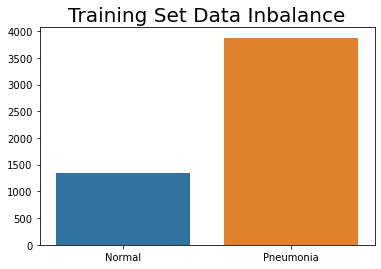

In [ ]:
# number of images for each class

train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/train/NORMAL', filename)
                     for filename in os.listdir(data_dir+'/train/NORMAL')])],
     'Pneumonia': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename)
                        for filename in os.listdir(data_dir+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

There appears to be **data class imbalance** in our dataset, with pnuemonia images having more samples compared to normal images. This is an issue as it will become harder for the model to generalize well as the model might get overfitted to a dominant class during training and thus perform badly when it sees a new dataset. I will try to compensate for this by weighting the loss of each class/label. This means that for the normal images, they will be given a higher weighting when evaluating the loss, and pneumonia images will be given a lower weighting.

Let's plot out some images with their labels. Notice the data augmentation being applied. During training, this image might be transformed to this form, but in another epoch, this image will receive another random transformation, and this DIVERSIFIES the dataset, since the model is not receiving each image in the same 'form' every epoch.

Label:  NORMAL (0)


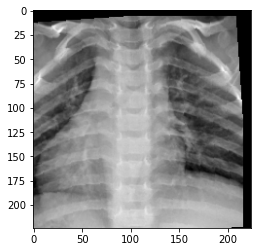

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*dataset[4])

Next, I plot out some images according to their labels, from the directory (not from the transformed dataset) as it is easier to separate between the classes.

Can you see any difference between the scans? Personally, I cannot since I am not a trained medical doctor specializing in pneumonia diagnosis. However, some expert practitioners might also encounter problems making correct diagnosis. And this is where deep learning comes in. It can help make the process faster and more efficient for practitioners by first separating scans that have a high and low probability of classification. For those with low probability, expert diagnoses can then be sought from the practitioners. It can even have the potential to identify and inform new ways to diagnosing diseases that were not known before.

In [ ]:

# Function for plotting samples
def plot_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

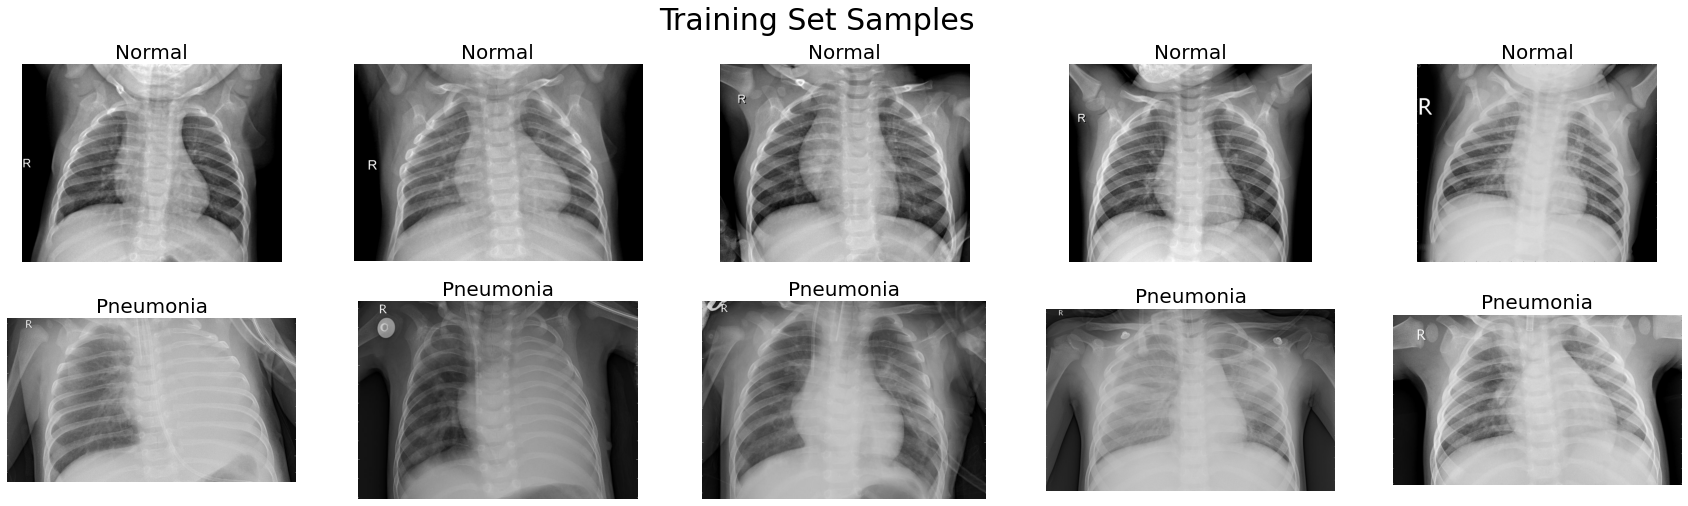

In [ ]:
## Plot training samples
rand_samples = random.sample([os.path.join(data_dir+'/train/NORMAL', filename)
                              for filename in os.listdir(data_dir+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(data_dir+'/train/PNEUMONIA', filename)
                   for filename in os.listdir(data_dir+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

<a id='Preparing_data'></a>
# 2. Preparing Train, Validation & Test Data

Now it's time to prepare our training, validation and testing dataset. We do this using the random_split function in torch. Here we split the train dataset into 70% train and 30% validation. Note that Pytorch doesn't have any built-in functions for stratified sampling, meaning that each sample will have the same proportion of classes as the original. There are a few written functions contributed by the community ([stratified sampling](https://github.com/jaideep11061982/Stratified_sampler_fastai/blob/master/batch_sampler.py)), but I have not tried it out yet.

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

In [ ]:
# set random seed so we get the same sampling every time for reproducibility

random_seed = 2020
torch.manual_seed(random_seed);

In [ ]:
train_size = round(len(dataset)*0.7) # 70%
val_size = len(dataset) - train_size # 30%

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(3651, 1565)

Here we select a batch size of 128 to perform mini_batch gradient descent/or other optimizers. This is a hyperparameter that can be tuned. The batch size means that the 3651 train images will be divided into batches of 128 images and gradient descent will be performed on each of this 128 images in one epoch (1 runthrough of the whole data).

In [ ]:
batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

Let's visualize a batch of data in a grid using the make_grid function from torchvision. We'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by matplotlib.

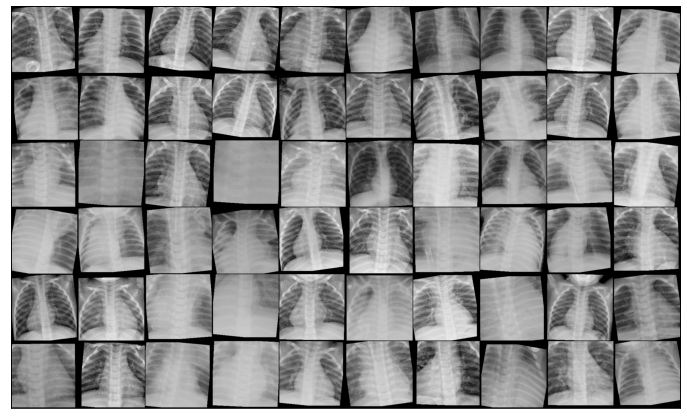

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break

show_batch(train_dl)

<a id='GPU'></a>
# 3. Set Up GPU

Now we set up the GPU so that training can be done faster. As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores that are optimized for performing expensive matrix operations on floating point numbers in a short time, which makes them ideal for training deep neural networks with many layers. [Kaggle](https://www.kaggle.com/) and [Google Colab](https://colab.research.google.com/) provide GPUs for limited free usage while [Google Cloud Platform](https://cloud.google.com/) and [Amazon Web Services](https://aws.amazon.com/) among others provide GPU-powered machines for rent.

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.

In [ ]:
torch.cuda.is_available()

True

We then define some helper functions to select which device to use depending on whether the GPU is available or not, and another to move our data and models to the device.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

Here, we define a `DeviceDataLoader` class to wrap our existing data loaders and move data to the selected device, as batches are accessed. Interestingly, we don't need to extend an existing class to create a PyTorch dataloader. All we need is an `__iter__` method to retrieve batches of data, and an `__len__` method to get the number of batches.

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

<a id='ModelClass'></a>
# 4. Creating Model Class

Finally it's time to create our model. We start by creating a class to initialize our model.

But first, we create some functions to calculate the metrics for our model performance.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

def F1_score(outputs, labels):
    _, preds = torch.max(outputs, dim=1)

    # precision, recall, and F1
    cm  = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))

    return precision,recall,f1,preds

Here we create a base model class with functions that will be called with the main model class.

* **training_step**: for loading the batch of train images and outputting its loss and accuracy. The output is used for computing the gradients and for combining with other batches later on
* **train_epoch_end**: this is used for combining the accuracies and losses of all the batches in each epoch for printing
* **validation_step**: same as for `training_step`, but for validation and test images
* **validation_epoch_end**: same as for `train_epoch_end`, but for validation images
* **epoch_end**: this takes all the outputs from `train_epoch_end` and `validation_epoch_end` and prints out the epoch performance
* **test_prediction**: for predictions on test images and returning the performance, labels and predictions

In [ ]:
class PneumoniaModelBase(nn.Module):

    # this is for loading the batch of train image and outputting its loss, accuracy
    # & predictions
    def training_step(self, batch, weight):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels, weight=weight)      # weighted compute loss
        acc,preds = accuracy(out, labels)                       # calculate accuracy

        return {'train_loss': loss, 'train_acc':acc}

    # this is for computing the train average loss and acc for each epoch
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]       # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['train_acc'] for x in outputs]          # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies

        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}

    # this is for loading the batch of val/test image and outputting its loss, accuracy,
    # predictions & labels
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels)                     # compute loss
        acc,preds = accuracy(out, labels)                       # calculate acc & get preds

        return {'val_loss': loss.detach(), 'val_acc':acc.detach(),
                'preds':preds.detach(), 'labels':labels.detach()}
    # detach extracts only the needed number, or other numbers will crowd memory

    # this is for computing the validation average loss and acc for each epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]         # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]            # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # this is for printing out the results after each epoch
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))

    # this is for using on the test set, it outputs the average loss and acc,
    # and outputs the predictions
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()]
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]

        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}

### ResNet

A [**Residual Network**](https://arxiv.org/abs/1512.03385) is just like any other CNN network architecture, except that they use a **residual block**. This adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers:

<img src = 'https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png' width="400">

<br>
This small change produces a drastic improvement in performance. It allows deeper networks to be trained without hurting performance as some layers can be skipped (residual blocks are also called skip-connections). You can refer to this blogpost to get a better understanding of how ResNet works:

https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec



Let's load the ResNet50 model and inspect it. I did not print it out here because it is very long. It has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. Note that the network has an `AdaptiveAvgPool2d` layer. This allows us to input images of any size into the model.

In [ ]:
resnet50 = models.resnet50(pretrained=True)
#resnet50

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


<img src = 'https://www.researchgate.net/publication/331364877/figure/fig3/AS:741856270901252@1553883726825/Left-ResNet50-architecture-Blocks-with-dotted-line-represents-modules-that-might-be.png' width="600">

<br>

From [Ji et al.(2019)](https://www.researchgate.net/publication/331364877_Optimized_Deep_Convolutional_Neural_Networks_for_Identification_of_Macular_Diseases_from_Optical_Coherence_Tomography_Images)

Next we create the class to setup the model.

Inside the __init__ constructor method, we load the **ResNet50** model, setting the `pretrained` parameter to true to load the pretrained weights. We then freeze the starting layers of the network (except the fully connected layer) and replaced the last layer (fc) with our own as our output has only 2 classes, whereas the ResNet50 was trained to output 1000 classes (refer to the model above).

The forward method is invoked when we pass a batch of inputs to the model.

In [ ]:
class PneumoniaResnet(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier

    def forward(self, xb):
        return self.network(xb)

#     def freeze(self):
#         # To freeze the residual layers
#         for param in self.network.parameters():
#             param.require_grad = False
#         for param in self.network.fc.parameters():
#             param.require_grad = True

#     def unfreeze(self):
#         # Unfreeze all layers
#         for param in self.network.parameters():
#             param.require_grad = True

Now we define the helper functions to fit and evaluate the model.

* **evaluate**: this simply calls the validation functions we defined in the base model class above and returns the output. This function is called inside the **fit** function.

* **get_lr**: for getting the learning rate of each epoch, so that one can store them if a learning rate scheduler is used, to keep track of the changes.

* **fit**: this is the main function to fit the model. We pass in our model and dataloaders and other hyperparameters. There are some codes that were commented out. These are some other methods that I tried but they did not seem to help with performance, such as weight decay, gradient clipping and one-cycle learning rate scheduler.

* `model.eval()` set specific layers like dropout and batchnorm to evaluation mode (dropout won’t drop activations, batchnorm will use running estimates instead of batch statistics) while `model.train()` will enable them.

* `torch.no_grad()` impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations but we won’t be able to backprop (which we don’t want in an evaluation  phase).

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, model, train_loader, val_loader, weight,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache() # release all the GPU memory cache
    history = {}

#    Set up cutom optimizer with weight decay
#    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

#     Set up one-cycle learning rate scheduler
#     sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
#                                                 steps_per_epoch=len(train_loader))
#   sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    optimizer = opt_func(model.parameters(), lr)

    best_loss = 1 # initialize best loss, which will be replaced with lower better loss
    for epoch in range(epochs):

        # Training Phase
        model.train()
        train_outputs = []
        lrs = []

        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']                          # get the loss
            train_outputs.append(outputs)
            # get the train average loss and acc for each epoch
            train_results = model.train_epoch_end(train_outputs)
            loss.backward()                                       # compute gradients

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()                                      # update weights
            optimizer.zero_grad()                                 # reset gradients

#             Record & update learning rate
#             lrs.append(get_lr(optimizer))
#             sched.step()

        # Validation phase
        val_results = evaluate(model, val_loader)

        # Save best loss
        if val_results['val_loss'] < best_loss and epoch + 1 > 15:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())
            #torch.save(model.state_dict(), 'best_model.pt')

        # print results
        model.epoch_end(epoch, train_results, val_results)

        # save results to dictionary
        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                 'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'], 'lrs':lrs}

        # update performance dictionary
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]

    model.load_state_dict(best_model_wts)                         # load best model

    return history, optimizer, best_loss

<a id='Train_model'></a>
# 5. Train and Evaluate Model

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the to_device function to move the model's parameters to the right device. This is important and is a step that is usually forgotten and will cause error.

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

model = to_device(PneumoniaResnet(), device)

Finally, it's time to train and evaluate our model on the entire train and validation sets.

Configurations like `batch size`, `learning rate` etc. need to picked in advance while training machine learning models, and are called **hyperparameters**. Picking the right hyperparameters is critical for training an accurate model within a reasonable amount of time, and is an active area of research and experimentation. Feel free to try different learning rates and see how it affects the training process.

In [ ]:
epochs = 20
lr = 0.0001
grad_clip = None
weight_decay = 1e-4
opt_func = torch.optim.Adam
# weighted loss for data class imbalance
weight = torch.FloatTensor([3876/(1342+3876), 1342/(1342+3876)]).to(device)


In [ ]:
history, optimizer, best_loss = fit(epochs, lr, model, train_dl, val_dl, weight,
                                    grad_clip=grad_clip,
                                    weight_decay=weight_decay,
                                    opt_func=opt_func)

Epoch [1], train_loss: 0.1621, train_acc: 0.9257, val_loss: 1.1241, val_acc: 0.7353
Epoch [2], train_loss: 0.0584, train_acc: 0.9785, val_loss: 0.1545, val_acc: 0.9479
Epoch [3], train_loss: 0.0479, train_acc: 0.9844, val_loss: 0.1475, val_acc: 0.9516
Epoch [4], train_loss: 0.0338, train_acc: 0.9865, val_loss: 0.1130, val_acc: 0.9688
Epoch [5], train_loss: 0.0216, train_acc: 0.9911, val_loss: 0.1435, val_acc: 0.9600
Epoch [6], train_loss: 0.0219, train_acc: 0.9936, val_loss: 0.1915, val_acc: 0.9413
Epoch [7], train_loss: 0.0243, train_acc: 0.9901, val_loss: 0.0832, val_acc: 0.9689
Epoch [8], train_loss: 0.0173, train_acc: 0.9933, val_loss: 0.0907, val_acc: 0.9723
Epoch [9], train_loss: 0.0128, train_acc: 0.9957, val_loss: 0.1275, val_acc: 0.9595
Epoch [10], train_loss: 0.0186, train_acc: 0.9933, val_loss: 0.1411, val_acc: 0.9650
Epoch [11], train_loss: 0.0228, train_acc: 0.9919, val_loss: 0.0871, val_acc: 0.9728
Epoch [12], train_loss: 0.0149, train_acc: 0.9952, val_loss: 0.1225, val_a

In [ ]:
print('Best loss is:', best_loss)

Best loss is: 0.07205121964216232


In [ ]:
# Save Model
bestmodel = {'model': PneumoniaResnet(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(bestmodel, 'PneumoniaResnet.pth')

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type PneumoniaResnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
# this is for loading the model from a previously saved one

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

#model = load_checkpoint('./PneumoniaResnet.pth')

<a id='Accuracy_loss_plots'></a>
# 6. Accuracy and Loss Plots

We made plots of the accuracy and loss for the training and validation data. This gives us an idea of how our model is performing (e.g., underfitting, overfitting).

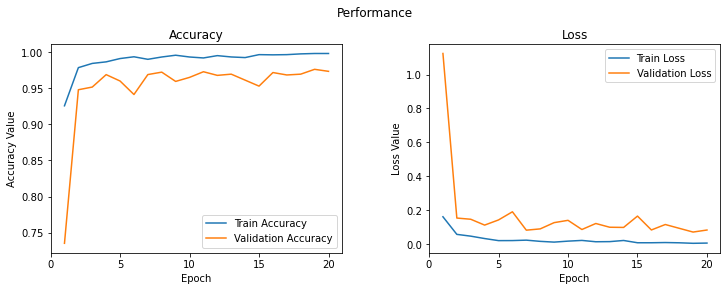

In [ ]:
# Plot Accuracy and Loss

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history['train_acc'], label='Train Accuracy')
ax1.plot(epoch_list, history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history['train_loss'], label='Train Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

<a id='Predict_test'></a>
# 7. Predicting on Test Set

It's time to test our model on the test set and see how well it performs on data that **it has not seen before**. This is important, as we want a model that can generalize to other datasets other than what it is trained on. A model that only does well on the training and validation dataset but not on a testing dataset is not a useful one.

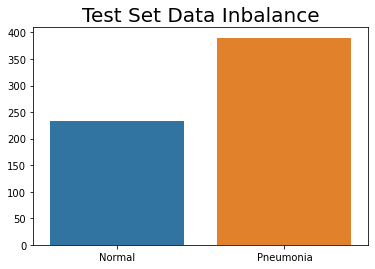

In [ ]:
# number of images for each class

test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/test/NORMAL', filename)
                     for filename in os.listdir(data_dir+'/test/NORMAL')])],
     'Pneumonia': [len([os.path.join(data_dir+'/test/PNEUMONIA', filename)
                        for filename in os.listdir(data_dir+'/test/PNEUMONIA')])]})

sns.barplot(data=test_samplesize).set_title('Test Set Data Inbalance', fontsize=20)
plt.show()

In [ ]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [model.validation_step(batch) for batch in test_loader]
    results = model.test_prediction(outputs)
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))

    return results['test_preds'], results['test_labels']

In [ ]:
test_dataset = ImageFolder(data_dir+'/test',
                           transform=tt.Compose([tt.Resize(255),
                                                 tt.CenterCrop(224),
                                                 tt.ToTensor()
                                                 #tt.Normalize(mean=[0.485, 0.456, 0.406],
                                                 #             std=[0.229, 0.224, 0.225],
                                                 #             inplace=True)
                                                ]))

In [ ]:
# Evaluate test set

test_dl = DataLoader(test_dataset, batch_size=256)
test_dl = DeviceDataLoader(test_dl, device)
preds,labels = test_predict(model, test_dl)

test_loss: 0.5160, test_acc: 0.9059


<a id='Evaluation_metrics'></a>
# 8. Model Evaluation Metrics

Next, we get a measure of how well our model is performing by evaluating several metrics of the predictions against the actual target_labels.

**Accuracy** is not a good evaluation metric when there is huge **data class imbalance**. Imagine that if we have 100 samples: 99 pneumonia and 1 normal, then a model that predicts everything as pneumonia will get an accuracy of 99%. In this case, its better to look at **precision and recall**, and their harmonic mean, the **F1 score**.

This can be visualized using a confusion matrix as well.

<img src = 'https://bk9zeg.bn.files.1drv.com/y4mZtoVgcWgAYE59g3lpWQ3PaZWMqnDN7gz1ir2LIgyPjR6a26Ij1vDBmjsETpEmvAkebvyLjSVofcRVSjW8Ux62r8_tIyIK6AZJ7GQOz_sWtAj_hdQIA57pbJaEpHJEeY_pG7odhdU1osvM7jHXfFzpVsIOt76oqNe39j4KZIFRDOguHUr5jPtDe0TIzNTLQuehcuQdw-aIjt7FR9D6Ti9-A?width=618&height=419&cropmode=none' width="600">

<Figure size 432x288 with 0 Axes>

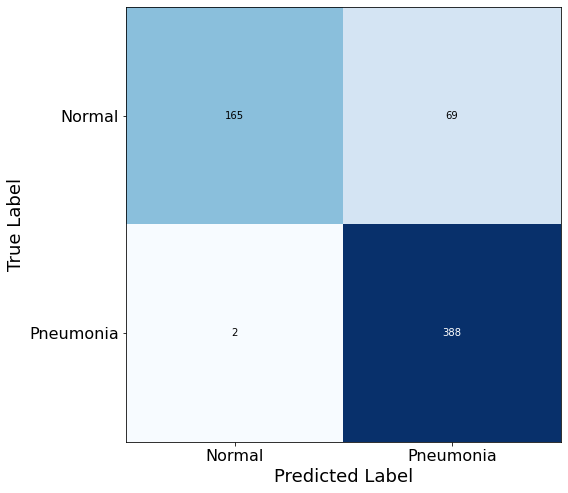

In [ ]:
# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [ ]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.89
Recall of the model is 0.99
Precision of the model is 0.85
F1 Score of the model is 0.92


Our model is performing quite well with a F1-score of about 90%. Precision is lower than recall, but this is expected due to the data class imbalance. The weightings can perhaps we tuned to improve the precision. However, recall and precision is balance and one has to be sacrificed for the other.

<a id='Plot_predictions'></a>
# 9. Plot Predictions against Actual Labels


Next, we print out some of the images and their respective predictions.

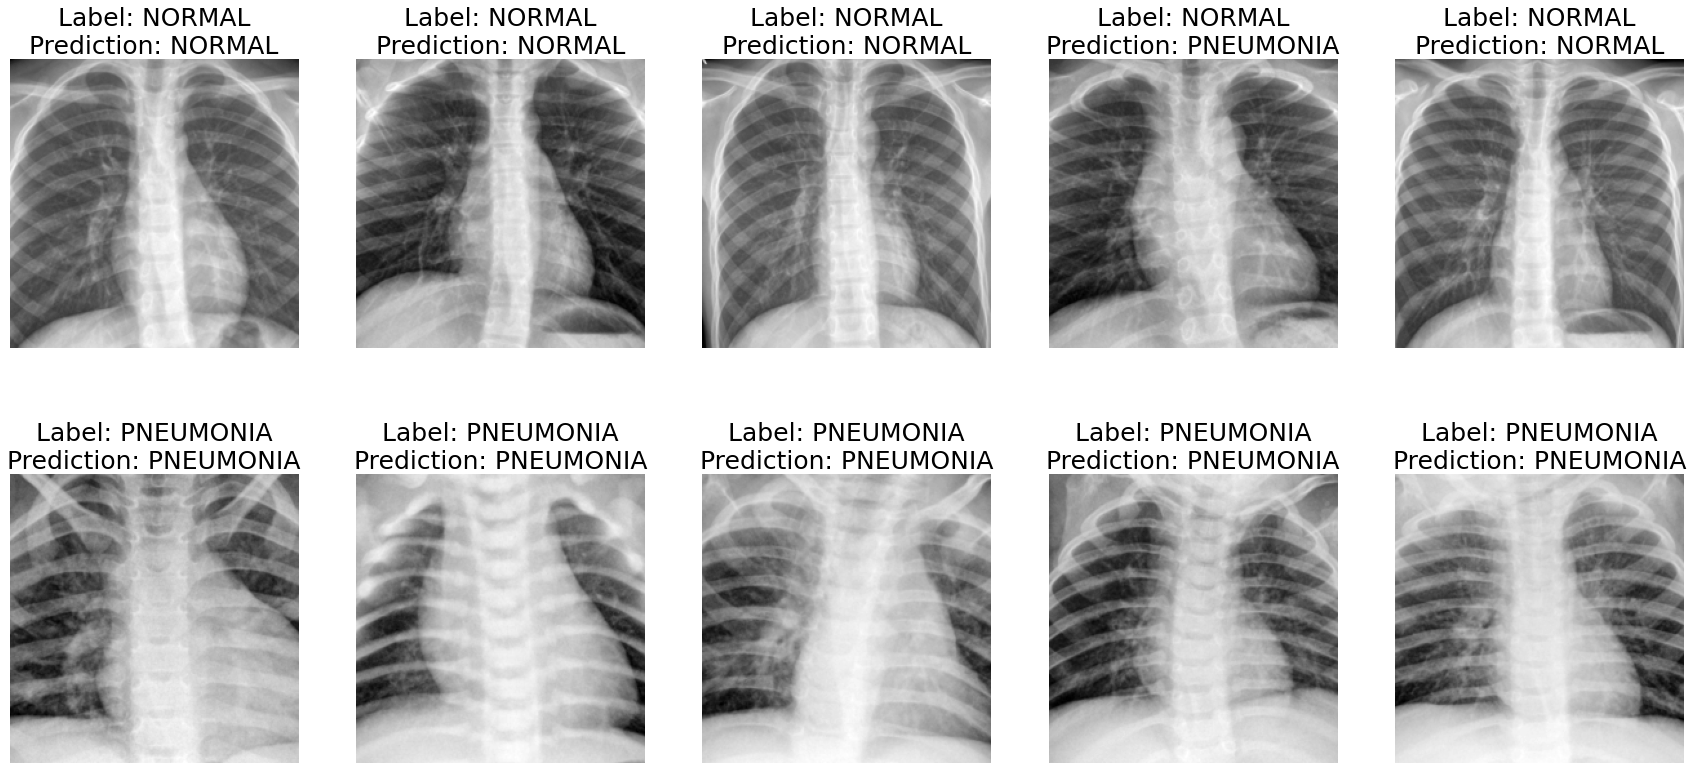

In [ ]:
# select 5 normal and 5 pneumonia images indices
idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1),
                             np.arange(start=500, stop=505, step=1)))

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

for c,i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Label: {}\nPrediction: {}'
                            .format(test_dataset.classes[label],
                                    test_dataset.classes[preds[i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')


<a id='Conclusion'></a>
# 10. Conclusion

In conclusion, our model performed reasonably well, as it manages to predict most of the pneumonia images. This is important as in healthcare diagnosis, accurate prediction of diseases saves lives. However, false positives can also increase the cost of healthcare, as more people with diseases are diagnosed with diseases. It can also lead to panic and affect people's physical and mental well-being. Better performance can be achieved with better tuning of the model hyperparameters. This is an iterative process, with lots of trial and error.

Below are some of the difficulties that I faced for this dataset:

* **Data class imbalance:** This is quite prevalent in the real world and as data scientists, we should all learn to embrace it and find ways to get around this problem. Usually, one way is to simply collect more data for the undersampled class. However, this is not possible for this dataset and especially for healthcare data, which is very difficult to collect and share. In this kernel, I used weighted loss to give more weights to the loss of the normal images. This weighting can be tuned as well to achieve the optimal performance. Stratified sampling is also important in this case, but pytorch does not yet have any built-in functions.

* **Overfitting:** This dataset is prone to overfitting as seen by the train and validation plots. Therefore, I only selected the model weights that achieved the best/lowest validation loss. However, sometimes the best validation loss are achieved in the early epochs, and it performs very badly on the test set, probably due to class imbalance when batching or sampling. For that reason, I have chosen to select the best validation loss only after certain epochs. I am not sure if this is a valid method. Please let me know if anyone has any comments on it!

Here are some other methods that I tried but did not improve or even hurt performance:

* **Learning rate scheduling using:**
   * [**Step learning rate:**](https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html#StepLR) decays the learning rate of each parameter group by gamma every setp_size epochs.
   * [**One fit cycle:**](https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html#OneCycleLR) The 1cycle policy anneals the learning rate from an initial learning rate to some maximum learning rate and then from that maximum learning rate to some minimum learning rate much lower than the initial learning rate. This policy was initially described in the paper [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120). Refer to this [post](https://sgugger.github.io/the-1cycle-policy.html) to get a better understanding.
* **Gradient Clipping:**  rescale/limit the values of gradients to a small range below a threshold to prevent undesirable changes in parameters due to large gradient values (exploding gradients), which makes the model unstable. Refer to this [post](https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48) for a better understanding.
* **Weight Decay:** a regularization technique which prevents the weights from becoming too large by adding an additional term (a tunable constant, aka weight decay multiplied by the sum of squares of our model parameters/weights) to the loss function. Refer to this [post](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab) for a better understanding. `Loss = MSE(y_hat, y) + wd * sum(w^2)`

That's it for now. If you like the kernel or learned something from it, please upvote it! Feel free to also check out my other kernels below. Good luck in your deep learning!